# Time Analysis

### Explanation
In this notebook will be analysed the temporal différence between the moment a command is sent by the state machine and the moment it is received by the Tool object.

First, let's import the necessary libraries and load the data.

## Libraries

In [27]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


Now let's load the two log files and parse them to extract the necessary information.

## Data

In [2]:
with open("../../../StateMachine/log.txt", "r") as f:
    log_sm_raw = f.read()

with open("../../log.txt", "r") as f:
    log_tool_raw = f.read()

log_sm_raw_lines   = log_sm_raw.split("\n")
log_tool_raw_lines = log_tool_raw.split("\n")

print("StateMachine log lines:", len(log_sm_raw_lines))
print("Tool log lines        :", len(log_tool_raw_lines))

# print an example of each log
print("StateMachine log example ================")
print(log_sm_raw_lines[len(log_sm_raw_lines) - 2])

StateMachine log lines: 15
Tool log lines        : 1892
StateMachine log example ================
[INFO] - 2024-05-21 12:08:21,156 - Transition    S0 - S0          -->    S1 - S1


In [3]:
# [INFO] - 2024-05-21 12:07:56,908 - Transition    S0 - S0          -->    S1 - S1

class LogLine:
    def __init__(self, type:str, date_time:datetime, message:str):
        self.type = type
        self.date_time = date_time
        self.message = message
    
    @classmethod
    def from_line(cls, line):
        if not line:
            return None
        parts = line.split(" - ")
        type = parts[0][1:-1]
        date_time_str = parts[1]
        date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S,%f')
        message = " - ".join(parts[2:])
        return cls(type, date_time, message)
    
    def __str__(self):
        return f"[{self.type}] - {self.date_time} - {self.message}"
    
    def __repr__(self):
        return f"LogLine({self.type}, {self.date_time}, {self.message})"

In [4]:
# Parse log lines
log_sm_lines = [LogLine.from_line(line) for line in log_sm_raw_lines]
log_tool_lines = [LogLine.from_line(line) for line in log_tool_raw_lines]

print("StateMachine log example ================")
print(log_sm_lines[len(log_sm_lines) - 2])
print(log_sm_lines[len(log_sm_lines) - 2].__dict__)

StateMachine log example ================
[INFO] - 2024-05-21 12:08:21.156000 - Transition    S0 - S0          -->    S1 - S1
{'type': 'INFO', 'date_time': datetime.datetime(2024, 5, 21, 12, 8, 21, 156000), 'message': 'Transition    S0 - S0          -->    S1 - S1'}


In [5]:
log_sm_df = pd.DataFrame([line.__dict__ for line in log_sm_lines if line is not None])
log_tool_df = pd.DataFrame([line.__dict__ for line in log_tool_lines if line is not None])

print(log_tool_df.head())

   type               date_time                                     message
0  INFO 2024-05-21 12:07:14.305             Starting the Leds API server...
1  INFO 2024-05-21 12:07:14.852      Starting the RecordAudio API server...
2  INFO 2024-05-21 12:07:14.897           Starting the ReadAudio process...
3  INFO 2024-05-21 12:07:15.610  Starting the Text Generation API server...
4  INFO 2024-05-21 12:07:16.621    Starting the CaptureImages API server...


In [49]:
# add column detail to log_tool_df with
# - "stop" if "Executing command: stop" in message
# - "start" if "Executing command: start" in message
# add column concerned_tool with the state concerned by the command

def parse_tool_message(message):
    possible_tools = {"T0_ReadAudio", "T1_PersonRecognition", "T2_Text_Generation", "T3_TTS", "T4_ActionSelection", "T5_PerformAction", "T6_RecordAudio", "T7_CaptureImages", "T8_STT", "T9_LEDS", "T10_RetrieveAndAugment"}
    for tool in possible_tools:
        if tool in message:
            return tool
    return None

log_tool_df["detail"] = np.where(log_tool_df["message"].str.contains("Executing command: stop"), "stop", np.where(log_tool_df["message"].str.contains("Executing command: start"), "start", None))
log_tool_df["concerned_tool"] = log_tool_df["message"].apply(lambda x: parse_tool_message(x))

# add column detail to log_sm_df with
# - "transition" if "Transition" in message
# add column transition_from and transition_to with the from and to states

def parse_transition_message(message):
    if not 'Transition' in message:
        return None, None
    parts = message.split()
    return parts[3], parts[7]

log_sm_df["detail"] = np.where(log_sm_df["message"].str.contains("Transition"), "transition", None)
log_sm_df["transition_from"] = log_sm_df["message"].apply(lambda x: parse_transition_message(x)[0] if x is not None else None)
log_sm_df["transition_to"] = log_sm_df["message"].apply(lambda x: parse_transition_message(x)[1] if x is not None else None)

log_sm_df.head()

,type,date_time,message,detail,transition_from,transition_to
0,INFO,2024-05-21 12:07:54.800,StateMachine initialized,None,None,None
1,INFO,2024-05-21 12:07:54.806,Starting StateMachine with initial state S0 - S0,None,None,None
2,INFO,2024-05-21 12:07:56.908,Transition S0 - S0 --> S1 - S1,transition,S0,S1
3,INFO,2024-05-21 12:07:59.112,Transition S1 - S1 --> S2 - S2,transition,S1,S2
4,INFO,2024-05-21 12:08:01.318,Transition S2 - S2 --> S3 - S3,transition,S2,S3


In [40]:
log_sm_tempdf = log_sm_df.copy()
log_tool_tempdf = log_tool_df.copy()

# new level column with 1 for info and 2 for error
log_sm_tempdf["level"] = log_sm_tempdf["type"].apply(lambda x: -1 if x == "INFO" else -2)
log_tool_tempdf["level"] = log_tool_tempdf["type"].apply(lambda x: 1 if x == "INFO" else 2)
log_combined = pd.concat([log_sm_tempdf, log_tool_tempdf])

log_combined = log_combined.sort_values(by="date_time")

       type               date_time  \
1879  ERROR 2024-05-21 12:08:16.692   
1880  ERROR 2024-05-21 12:08:16.693   
1881  ERROR 2024-05-21 12:08:16.695   
1882   INFO 2024-05-21 12:08:16.696   
1883  ERROR 2024-05-21 12:08:16.696   
1884   INFO 2024-05-21 12:08:16.697   
11     INFO 2024-05-21 12:08:16.750   
12     INFO 2024-05-21 12:08:18.954   
13     INFO 2024-05-21 12:08:21.156   
1885   INFO 2024-05-21 12:08:22.248   
1886   INFO 2024-05-21 12:08:22.351   
1889   INFO 2024-05-21 12:08:27.757   
1887   INFO 2024-05-21 12:08:27.757   
1888   INFO 2024-05-21 12:08:27.757   
1890   INFO 2024-05-21 12:08:27.758   

                                                message  level  
1879  SpeechToText: [Errno 1094995529] Invalid data ...      2  
1880  SpeechToText: [Errno 1094995529] Invalid data ...      2  
1881  SpeechToText: [Errno 1094995529] Invalid data ...      2  
1882  Executing command: stop (Tools/T8_STT/fast_com...      1  
1883  SpeechToText: [Errno 1094995529] Invalid dat

## First Analysis

Let's start by plotting all the commands sent by the state machine and the moment they were received by the Tool object.

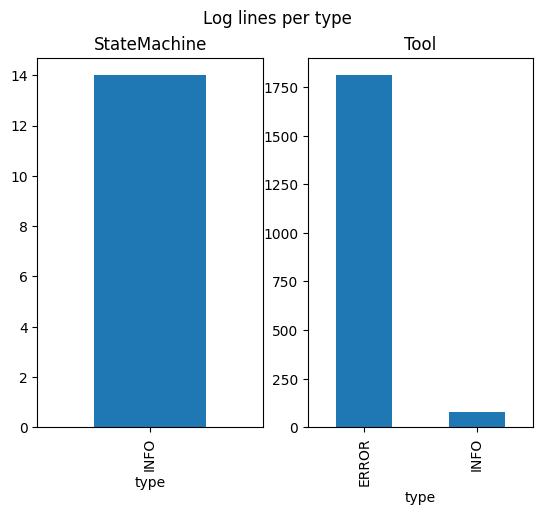

In [6]:
# plot the number of log lines per type
fig = plt.figure()
plt.subplot(1, 2, 1)
log_sm_df.groupby("type").size().plot(kind='bar', title="StateMachine")

plt.subplot(1, 2, 2)
log_tool_df.groupby("type").size().plot(kind='bar', title="Tool")
# sup title
plt.suptitle("Log lines per type")
plt.show()


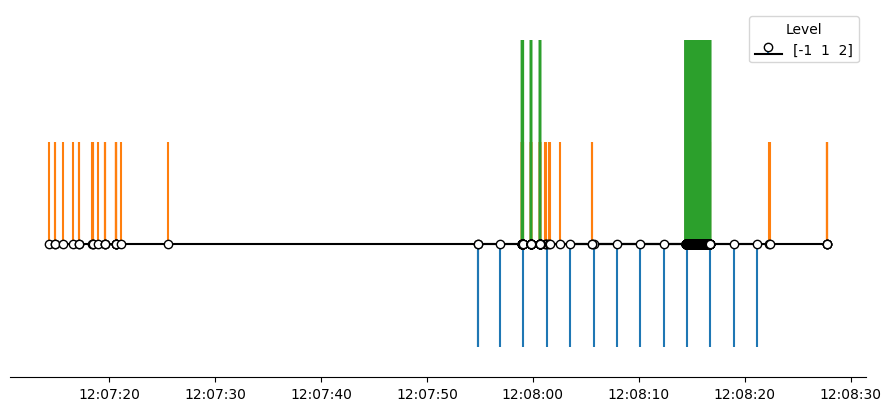

In [35]:
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)

for i, (key, grp) in enumerate(log_combined.groupby(["level"])):
    markerline, stemline, baseline = ax.stem(grp["date_time"], grp["level"], linefmt=f"C{i}-", basefmt="k-", label=key)

    plt.setp(markerline, mec="k", mfc="w", zorder=3)
    markerline.set_ydata(np.zeros(len(grp["date_time"])))

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

plt.legend([log_combined["level"].unique()], title="Level")
ax.margins(y=0.1)

plt.show()
